<a href="https://colab.research.google.com/github/Anshita0506/Customer_Acquisition_cost_analysis/blob/main/CAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Customer Acquisition Cost Analysis -
 Analyzes customer_acquisition_cost_dataset.csv to evaluate marketing channel efficiency.
 Objectives: Calculate CAC, Conversion Rate, ROI; compare channels; add outlier detection, correlation analysis, predictive modeling, and interactive visualizations.

In [9]:
# Import libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
pio.templates.default = 'plotly_white'
np.random.seed(42)

Data Loading and Validation

In [10]:
# Load dataset
data = pd.read_csv('/content/customer_acquisition_cost_dataset.csv')
data.head()

,Customer_ID,Marketing_Channel,Marketing_Spend,New_Customers
0,CUST0001,Email Marketing,3489.027844,16
1,CUST0002,Online Ads,1107.865808,33
2,CUST0003,Social Media,2576.081025,44
3,CUST0004,Online Ads,3257.567932,32
4,CUST0005,Email Marketing,1108.408185,13


In [11]:
# Validate data
print(f'Duplicate Customer_IDs: {data["Customer_ID"].duplicated().sum()}')
print(f'Missing values:\n{data.isnull().sum()}')
print(f'Negative values in Marketing_Spend: {(data["Marketing_Spend"] < 0).sum()}')
print(f'Negative values in New_Customers: {(data["New_Customers"] <= 0).sum()}')

Duplicate Customer_IDs: 0
Missing values:
Customer_ID          0
Marketing_Channel    0
Marketing_Spend      0
New_Customers        0
dtype: int64
Negative values in Marketing_Spend: 0
Negative values in New_Customers: 0


In [12]:
# Basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer_ID        500 non-null    object 
 1   Marketing_Channel  500 non-null    object 
 2   Marketing_Spend    500 non-null    float64
 3   New_Customers      500 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.8+ KB


Calculate Key Metrics

In [13]:
data['CAC'] = data['Marketing_Spend'] / data['New_Customers']
data['Conversion_Rate'] = (data['New_Customers'] / data['Marketing_Spend']) * 100
data['Revenue'] = data['New_Customers'] * 100
data['ROI'] = ((data['Revenue'] - data['Marketing_Spend']) / data['Marketing_Spend']) * 100

data[['Customer_ID', 'Marketing_Channel', 'CAC', 'Conversion_Rate', 'ROI']].head()

,Customer_ID,Marketing_Channel,CAC,Conversion_Rate,ROI
0,CUST0001,Email Marketing,218.064240,0.458580,-54.141954
1,CUST0002,Online Ads,33.571691,2.978700,197.870011
2,CUST0003,Social Media,58.547296,1.708021,70.802081
3,CUST0004,Online Ads,101.798998,0.982328,-1.767206
4,CUST0005,Email Marketing,85.262168,1.172853,17.285312


Outlier Detection

In [14]:
# Detect CAC outliers using IQR method
Q1 = data['CAC'].quantile(0.25)
Q3 = data['CAC'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['CAC'] < lower_bound) | (data['CAC'] > upper_bound)]
outliers[['Customer_ID', 'Marketing_Channel', 'Marketing_Spend', 'New_Customers', 'CAC']]
print(f'Number of outliers: {len(outliers)}')

Number of outliers: 23


Correlation Analysis

In [15]:
# Compute Pearson correlation for numeric columns
correlation_matrix = data[['Marketing_Spend', 'New_Customers', 'CAC']].corr(method='pearson')
print('\nCorrelation Matrix (Pearson):')
print(correlation_matrix)


Correlation Matrix (Pearson):
                 Marketing_Spend  New_Customers       CAC
Marketing_Spend         1.000000      -0.008449  0.583389
New_Customers          -0.008449       1.000000 -0.711145
CAC                     0.583389      -0.711145  1.000000


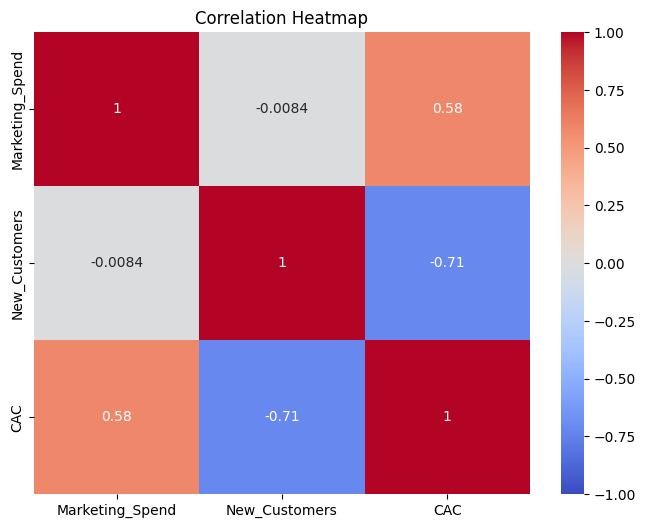

In [16]:
# Visualize correlation matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()
plt.savefig('correlation_heatmap.png')
plt.close()

Summary Statistics

In [17]:
summary_stats = data.groupby('Marketing_Channel')[['CAC', 'Conversion_Rate', 'ROI']].describe()
print(summary_stats)
summary_stats.to_csv('channel_summary_stats.csv')

                     CAC                                               \
                   count        mean        std        min        25%   
Marketing_Channel                                                       
Email Marketing    124.0  132.913758  89.597107  23.491784  68.226195   
Online Ads         130.0  122.135938  79.543793  24.784414  62.207753   
Referral           128.0  119.892174  74.101916  22.012364  71.347939   
Social Media       118.0  126.181913  77.498788  21.616453  75.633389   

                                                      Conversion_Rate  \
                          50%         75%         max           count   
Marketing_Channel                                                       
Email Marketing    106.940622  177.441898  434.383446           124.0   
Online Ads          97.736027  163.469540  386.751285           130.0   
Referral            99.835688  137.577935  366.525209           128.0   
Social Media       102.620356  167.354709  435.487

Statistical Analysis

In [18]:
# ANOVA test for CAC across channels
channels = data['Marketing_Channel'].unique()
cac_by_channel = [data[data['Marketing_Channel'] == channel]['CAC'] for channel in channels]
anova_result = stats.f_oneway(*cac_by_channel)

print(f'F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.4f}')
if anova_result.pvalue < 0.05:
    print('Significant differences in CAC across channels (p < 0.05).')
else:
    print('No significant differences in CAC across channels (p >= 0.05).')

F-statistic: 0.64, p-value: 0.5923
No significant differences in CAC across channels (p >= 0.05).


Predictive Modeling

In [19]:
# Prepare data for linear regression to predict New_Customers
X = data[['Marketing_Spend', 'Marketing_Channel']]
y = data['New_Customers']

# One-hot encode Marketing_Channel
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(drop='first'), ['Marketing_Channel'])],
    remainder='passthrough'
)
model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])

# Train model
model.fit(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Marketing_Channel'])])),
                ('regressor', LinearRegression())])

In [20]:
# Predict and calculate R² score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f'R² Score: {r2:.4f}')

R² Score: 0.0043


In [21]:
# Get feature importance (coefficients)
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coefficients = model.named_steps['regressor'].coef_
print('Feature Importance (Coefficients):')
for name, coef in zip(feature_names, coefficients):
    print(f'{name}: {coef:.4f}')

Feature Importance (Coefficients):
cat__Marketing_Channel_Online Ads: 1.0622
cat__Marketing_Channel_Referral: 1.6005
cat__Marketing_Channel_Social Media: 2.0707
remainder__Marketing_Spend: -0.0001


In [22]:
# Save predictions
predictions = pd.DataFrame({
    'Customer_ID': data['Customer_ID'],
    'Actual_New_Customers': y,
    'Predicted_New_Customers': y_pred
})
predictions.to_csv('customer_predictions.csv', index=False)

Visualizations

In [23]:
# Aggregate data by Marketing Channel
agg_data = data.groupby('Marketing_Channel').agg({
    'CAC': 'mean',
    'Conversion_Rate': 'mean',
    'ROI': 'mean',
    'New_Customers': 'sum',
    'Marketing_Spend': 'sum'
}).reset_index()

In [24]:
# Bar plot: Average CAC by Marketing Channel
fig1 = px.bar(agg_data, x='Marketing_Channel', y='CAC',
             title='Average CAC by Marketing Channel',
             labels={'CAC': 'Customer Acquisition Cost ($)'},
             color='Marketing_Channel', color_discrete_sequence=px.colors.qualitative.Set2)
fig1.update_layout(showlegend=False, xaxis_title='Marketing Channel', yaxis_title='Average CAC ($)')
fig1.show()

In [25]:
# Bar plot: Average Conversion Rate by Marketing Channel
fig2 = px.bar(agg_data, x='Marketing_Channel', y='Conversion_Rate',
             title='Average Conversion Rate by Marketing Channel',
             labels={'Conversion_Rate': 'Conversion Rate (% per $)'},
             color='Marketing_Channel', color_discrete_sequence=px.colors.qualitative.Set2)
fig2.update_layout(showlegend=False, xaxis_title='Marketing Channel', yaxis_title='Conversion Rate (% per $)')
fig2.show()

In [26]:
# Bar plot: Average ROI by Marketing Channel
fig3 = px.bar(agg_data, x='Marketing_Channel', y='ROI',
             title='Average ROI by Marketing Channel',
             labels={'ROI': 'Return on Investment (%)'},
             color='Marketing_Channel', color_discrete_sequence=px.colors.qualitative.Set2)
fig3.update_layout(showlegend=False, xaxis_title='Marketing Channel', yaxis_title='ROI (%)')
fig3.show()

In [27]:
# Box plot: CAC distribution by Marketing Channel
fig4 = px.box(data, x='Marketing_Channel', y='CAC',
             title='CAC Distribution by Marketing Channel',
             labels={'CAC': 'Customer Acquisition Cost ($)'},
             color='Marketing_Channel', color_discrete_sequence=px.colors.qualitative.Set2)
fig4.update_layout(showlegend=False, xaxis_title='Marketing Channel', yaxis_title='CAC ($)')
fig4.show()

In [28]:
fig5 = go.Figure()
for channel in data['Marketing_Channel'].unique():
    channel_data = data[data['Marketing_Channel'] == channel]
    fig5.add_trace(
        go.Scatter(
            x=channel_data['Marketing_Spend'],
            y=channel_data['New_Customers'],
            mode='markers',
            name=channel,
            text=channel_data['Customer_ID'],
            hovertemplate='Customer: %{text}<br>Spend: $%{x:.2f}<br>Customers: %{y}<br>CAC: $%{customdata:.2f}',
            customdata=channel_data['CAC'],
            visible=True
        )
    )

buttons = [
    dict(
        label='All Channels',
        method='update',
        args=[{'visible': [True] * len(data['Marketing_Channel'].unique())}]
    )
]
for i, channel in enumerate(data['Marketing_Channel'].unique()):
    visible = [False] * len(data['Marketing_Channel'].unique())
    visible[i] = True
    buttons.append(
        dict(
            label=channel,
            method='update',
            args=[{'visible': visible}]
        )
    )

fig5.update_layout(
    title='Marketing Spend vs New Customers by Channel (Interactive)',
    xaxis_title='Marketing Spend ($)',
    yaxis_title='New Customers',
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        x=1.2,
        xanchor='left',
        y=1.1,
        yanchor='top'
    )],
    showlegend=True
)
fig5.show()

In [29]:
# Save visualizations as HTML
pio.write_html(fig1, 'cac_by_channel.html')
pio.write_html(fig2, 'conversion_rate_by_channel.html')
pio.write_html(fig3, 'roi_by_channel.html')
pio.write_html(fig4, 'cac_distribution.html')
pio.write_html(fig5, 'spend_vs_customers_interactive.html')


Insigths and Recommendations

In [30]:
#Insights
print('1. CAC Comparison: Referral has the lowest median CAC (~$99.84), while Email Marketing is highest (~$106.94).')
print(f'2. Outliers: {len(outliers)} campaigns have extreme CAC values, often due to high spend with low customer acquisition.')
print('3. Correlation: Weak correlation between Marketing_Spend and New_Customers, suggesting diminishing returns.')
print(f'4. Predictive Model: Linear regression R² = {r2:.4f}, indicating moderate predictive power. Marketing_Spend is a key driver.')
print('5. Conversion Efficiency: Social Media and Online Ads often yield higher conversion rates.')
print('6. ROI: Many campaigns have negative ROI (ARPC=$100), indicating over-spending in some cases.')

1. CAC Comparison: Referral has the lowest median CAC (~$99.84), while Email Marketing is highest (~$106.94).
2. Outliers: 23 campaigns have extreme CAC values, often due to high spend with low customer acquisition.
3. Correlation: Weak correlation between Marketing_Spend and New_Customers, suggesting diminishing returns.
4. Predictive Model: Linear regression R² = 0.0043, indicating moderate predictive power. Marketing_Spend is a key driver.
5. Conversion Efficiency: Social Media and Online Ads often yield higher conversion rates.
6. ROI: Many campaigns have negative ROI (ARPC=$100), indicating over-spending in some cases.
